<a href="https://colab.research.google.com/github/osmaanural/KolonCaClass/blob/main/koloncaclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.utils as vutils
import cv2
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Veri Setinin Hazırlanması ve Yüklenmesi

In [2]:
def data_loader(batch_size=32):
  transform=transforms.Compose([
      #transforms.Grayscale(num_output_channels=1),
      transforms.Resize((256,256)),
      transforms.ToTensor(),
      transforms.Normalize((0.5), (0.5))
  ])

  train_dataset=datasets.ImageFolder(root="/content/drive/Othercomputers/Dizüstü Bilgisayarım/Masaüstü/kolonca/Split_Data/Split_Data/train",transform=transform)
  test_dataset=datasets.ImageFolder(root="/content/drive/Othercomputers/Dizüstü Bilgisayarım/Masaüstü/kolonca/Split_Data/Split_Data/test",transform=transform)

  train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
  test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

  return train_loader,test_loader

train_loader,test_loader=data_loader()

In [ ]:
len(train_loader)

249

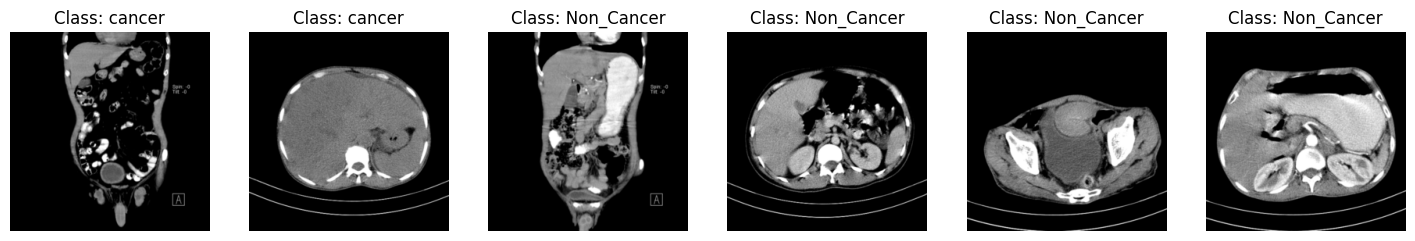

In [ ]:
# 1. Görüntü gösterme fonksiyonu
def imshow(img):
    img = img / 2 + 0.5  # normalize düzeltmesi
    np_img = img.numpy()
    # [C,H,W] -> [H,W,C]
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

# 3. Train loader'dan bir batch çekme
def get_sample_images(train_loader):
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    return images, labels

# 4. Görselleştirme fonksiyonu
def visualize(n=6):
    # Burada train_dataset'i de alıyoruz
    train_loader, test_loader = data_loader()
    train_dataset = train_loader.dataset  # ImageFolder dataset

    images, labels = get_sample_images(train_loader)

    plt.figure(figsize=(n * 3, 3))  # Görsel boyutu: n*3 genişlik
    for i in range(n):
        plt.subplot(1, n, i + 1)
        imshow(images[i])
        # label'i klasör adı ile göster
        class_name = train_dataset.classes[labels[i].item()]
        plt.title(f"Class: {class_name}")
        plt.axis("off")
    plt.show()


visualize()


#Gerekli Fonskiyonlar

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def training(model, train_loader, optimizer, criterion, epochs,early_stopping, device):
    model = model.to(device)
    train_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        all_preds = []
        all_labels = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Sınıf tahminlerini al
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Metrikleri hesapla
        acc = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f} | Acc: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

        if early_stopping(avg_loss):
            print(f"⏹️ Early stopping activated at epoch {epoch+1}")
            break

    # Loss grafiği
    plt.figure()
    plt.plot(range(1, len(train_losses)+1), train_losses, linestyle="--", label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Model Loss")
    plt.legend()
    plt.show()


In [21]:
def hiperparametre(modelname):
  if modelname==modelcnn:
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(modelcnn.parameters(),lr=lr)
    early_stopping=EarlyStopping(patience=5,min_delta=0.00001)
  else:
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(modelname.classifier[1].parameters(),lr=lr)
    early_stopping=EarlyStopping(patience=5,min_delta=0.00001)
    # scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1) ## öğrenme katasyısını kademeli olarak düşürür.


  return criterion,optimizer,early_stopping


In [22]:
def modelsec(modeladi,device):
  model = modeladi(pretrained=True)
  num_ftrs=model.classifier[1].in_features ##mevcut sınıflandırıcıların temel özelliklerini alır
  model.classifier[1]=nn.Linear(num_ftrs,2) # kendi veri setimize göre uyarlarız. 2 sınıf olduğu için
  model=model.to(device)
  return model.to(device)


# CNN

In [19]:
## Modelin Oluşturulması

class CNN(nn.Module):

  def __init__(self):
    super(CNN,self).__init__()
    self.conv1=nn.Conv2d(3,16,3,padding=1)   #256--> 128
    self.relu=nn.ReLU()
    self.pool=nn.MaxPool2d(2,2)
    self.conv2=nn.Conv2d(16,32,3,padding=1)   # 128--> 64
    self.conv3=nn.Conv2d(32,64,3,padding=1)   # 64--> 32
    # self.conv4=nn.Conv2d(64,128,3,padding=1)  # 32--> 16
    self.bn1=nn.BatchNorm2d(16)
    self.dropout=nn.Dropout(0.25)
    self.fc1=nn.Linear(64*32*32,128)
    self.fc2=nn.Linear(128,2)

  def forward(self,x):
    x=self.conv1(x)  ## 16,256,256
    x=self.relu(x)
    x=self.pool(x)   ## 256--> 128
    x=self.bn1(x)
    # x=self.dropout(x)

    x=self.conv2(x)  ## 32,128,128
    x=self.relu(x)
    x=self.pool(x)   ## 128--> 64

    # x=self.dropout(x)

    x=self.conv3(x)  ## 64,64,64
    x=self.relu(x)
    x=self.pool(x)   ## 64 --> 32

    x=self.dropout(x)

    # x=self.conv4(x)  ## 128,32,32
    # x=self.relu(x)
    # x=self.pool(x)   ## 32--> 16
    # # x=self.dropout(x)

    x=x.view((x.size(0)),-1) ##düzleştirmek için 128,16,16  vekötr haline getirildi.
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)

    return x




In [26]:
## Call Back Tanımlanması
class EarlyStopping:
  def __init__(self,patience=5,min_delta=0.00001):
    self.patience=patience
    self.min_delta=min_delta
    self.counter=0
    self.best_loss=None

  def __call__(self,loss):
    if self.best_loss is None or loss>self.best_loss-self.min_delta:
      self.best_loss=loss
      self.counter=0
    else:
      self.counter+=1
    if self.counter>=self.patience:
      return True
    return False



In [27]:
## Model Eğitimi
epochs=100
lr=0.0001
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
modelcnn=CNN()
criterion,optimizer,early_stopping=hiperparametre(modelcnn)

Epoch 1/50 | Loss: 0.205420 | Acc: 0.9094 | Precision: 0.6064 | Recall: 0.6012 | F1: 0.6035
Epoch 2/50 | Loss: 0.039291 | Acc: 0.9884 | Precision: 0.9884 | Recall: 0.9875 | F1: 0.9879
Epoch 3/50 | Loss: 0.013318 | Acc: 0.9974 | Precision: 0.9975 | Recall: 0.9970 | F1: 0.9972
Epoch 4/50 | Loss: 0.008824 | Acc: 0.9982 | Precision: 0.9983 | Recall: 0.9981 | F1: 0.9982
⏹️ Early stopping activated at epoch 4


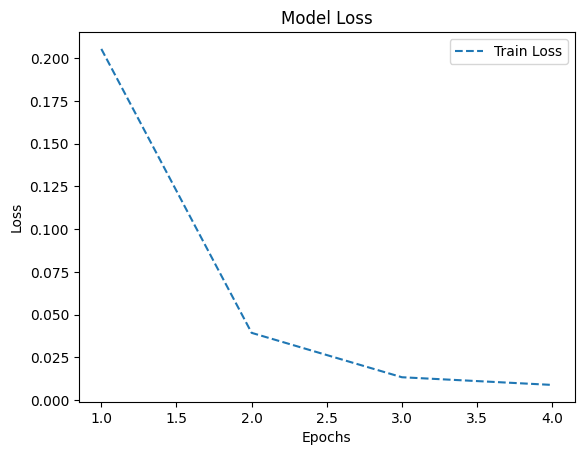

In [ ]:
 training(modelcnn,train_loader,optimizer,criterion,epochs=50,early_stopping=early_stopping,device=device)

Test Accuracy: 99.65%
Precision: 1.00
Recall:    1.00
F1 Score:  1.00


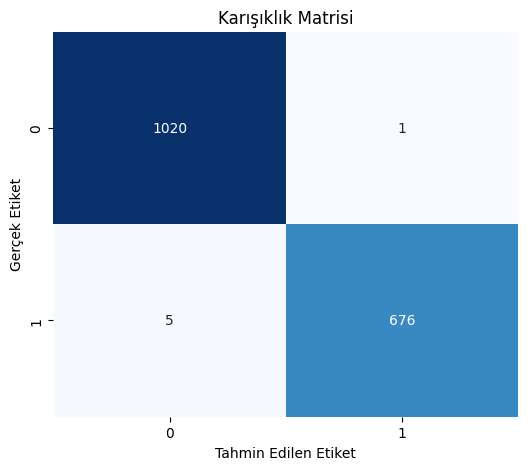

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
model.to(device)
model.eval()
correct = 0
total = 0
all_pred = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_pred.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 🔢 Doğruluk ve diğer metrikler
print(f"Test Accuracy: {100 * correct / total:.2f}%")

precision = precision_score(all_labels, all_pred, average="macro", zero_division=0)
recall = recall_score(all_labels, all_pred, average="macro", zero_division=0)
f1 = f1_score(all_labels, all_pred, average="macro", zero_division=0)

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

# 📊 Karışıklık Matrisi (Confusion Matrix)
cm = confusion_matrix(all_labels, all_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.title("Karışıklık Matrisi")
plt.show()


In [ ]:
torch.save(model,"modelkolonca.pt")

# EfficientNetB0


In [16]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# modelsec sadece model döndürüyorsa:
modelefficient = modelsec(efficientnet_b0, device)  # DİKKAT: tek değişken


In [29]:
criterionefficient,optimizerefficient,early_stopping_eff=hiperparametre(modelefficient)

Epoch 1/50 | Loss: 0.626820 | Acc: 0.6457 | Precision: 0.6454 | Recall: 0.5807 | F1: 0.5599
Epoch 2/50 | Loss: 0.557772 | Acc: 0.7266 | Precision: 0.7408 | Recall: 0.6812 | F1: 0.6850
Epoch 3/50 | Loss: 0.521956 | Acc: 0.7546 | Precision: 0.7573 | Recall: 0.7222 | F1: 0.7291
Epoch 4/50 | Loss: 0.493159 | Acc: 0.7790 | Precision: 0.7810 | Recall: 0.7516 | F1: 0.7592
Epoch 5/50 | Loss: 0.472476 | Acc: 0.7859 | Precision: 0.7854 | Recall: 0.7620 | F1: 0.7688
Epoch 6/50 | Loss: 0.463793 | Acc: 0.7948 | Precision: 0.7939 | Recall: 0.7726 | F1: 0.7792
⏹️ Early stopping activated at epoch 6


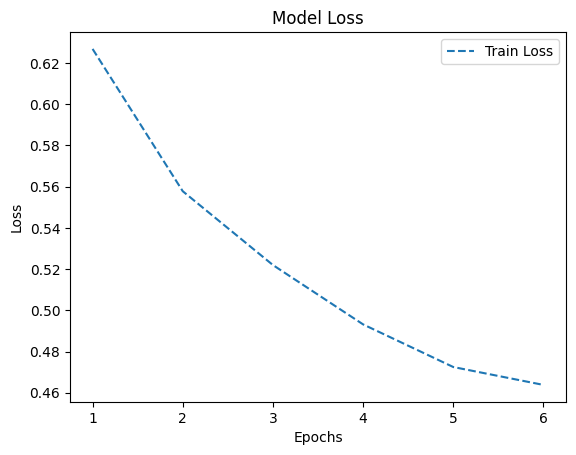

In [30]:
## TRAİN
training(modelefficient,train_loader,optimizerefficient,criterionefficient,epochs=50,early_stopping=early_stopping_eff,device=device)

Test Accuracy: 81.73%
Precision: 0.83
Recall:    0.79
F1 Score:  0.80


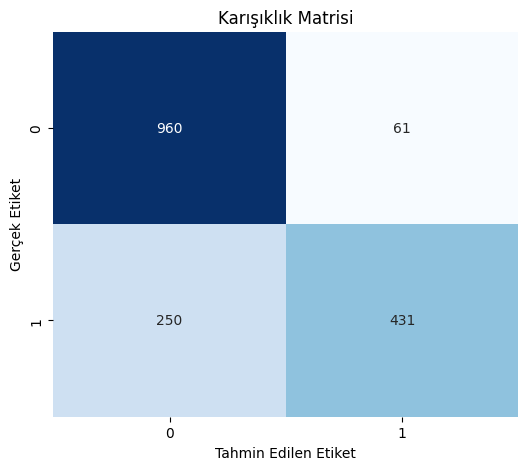

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
modelefficient.to(device)
modelefficient.eval()
correct = 0
total = 0
all_pred = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelefficient(images)
        _, predicted = torch.max(outputs, 1)
        all_pred.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 🔢 Doğruluk ve diğer metrikler
print(f"Test Accuracy: {100 * correct / total:.2f}%")

precision = precision_score(all_labels, all_pred, average="macro", zero_division=0)
recall = recall_score(all_labels, all_pred, average="macro", zero_division=0)
f1 = f1_score(all_labels, all_pred, average="macro", zero_division=0)

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

# 📊 Karışıklık Matrisi (Confusion Matrix)
cm = confusion_matrix(all_labels, all_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.title("Karışıklık Matrisi")
plt.show()


In [34]:
torch.save(modelefficient,"modelefficient.pt")